In [2]:
import numpy as np
import pandas as pd
#from osgeo import gdal
import matplotlib.pyplot as plt

%matplotlib qt


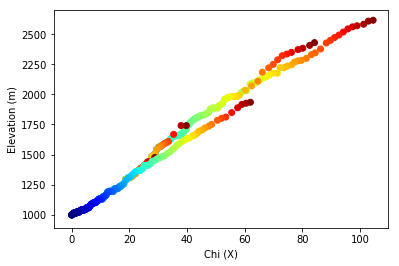

In [104]:
# plt.figure()

# for i in range(0, len(np.unique(data_05['chan_number']))):
#     chan_index = data_05['chan_number'] == i
#     chan = data_05[chan_index] # selects the "True" rows recorded in the boolean index
#     chi = chan['chi']
#     elevation = chan['elevation']
#     plt.scatter(chi, elevation, c=chi, cmap=plt.get_cmap("jet"))
# plt.xlabel('Chi (X)')
# plt.ylabel('Elevation (m)')
# plt.show()